In [152]:
from webscraping.scraper import fetch_all_csv_from_drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from itertools import combinations

import os
import pandas as pd
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from io import BytesIO
import networkx as nx

In [15]:

def fetch_all_csv_from_drive(folder_id, credentials_path):

    SCOPES = ["https://www.googleapis.com/auth/drive"]
    credentials = service_account.Credentials.from_service_account_file(credentials_path, scopes=SCOPES)
    service = build("drive", "v3", credentials=credentials)

    query = f"'{folder_id}' in parents and mimeType='text/csv'"
    all_dataframes = []
    page_token = None

    while True:
        results = service.files().list(
            q=query,
            fields="nextPageToken, files(id, name)",
            pageToken=page_token
        ).execute()

        files = results.get("files", [])
        page_token = results.get("nextPageToken")

        if not files:
            print("No more CSV files found in the folder.")
            break

        for file in files:
            file_id = file["id"]
            file_name = file["name"]

            print(f"Downloading {file_name}...")

            request = service.files().get_media(fileId=file_id)
            file_data = BytesIO()
            downloader = MediaIoBaseDownload(file_data, request)

            done = False
            while not done:
                status, done = downloader.next_chunk()
                print(f"Progress: {int(status.progress() * 100)}%")

            file_data.seek(0)
            df = pd.read_csv(file_data)
            df["source_file"] = file_name
            all_dataframes.append(df)

        if not page_token:
            break

    return pd.concat(all_dataframes, ignore_index=True) if all_dataframes else None


In [16]:
folder_id = "1EafyzmaIUfPRXzwt8s4TSOQcQ00U4BTF"
credentials_path = "/Users/rahilshaik/voyager-voting-clustering/voyager-voting-clusters-3e85add6e250.json"

df = fetch_all_csv_from_drive(folder_id, credentials_path)

if df is not None:
    print(df.head())

Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 

In [183]:
def filter_source_files_between(df, lower, upper): # keep in mind that the soruce files start with 4
    df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)
    filtered_df = df[(df["file_num"] >= lower) & (df["file_num"] <= upper)]
    filtered_df = filtered_df.drop(columns=["file_num"])

    return filtered_df


In [184]:
df_tst = filter_source_files_between(df, 4, 196)
df_tst["4"] = df_tst["4"].fillna(0)
df_tst["5"] = df_tst["5"].fillna(0)
df_tst["3"] = df_tst["3"].fillna(0)
df_tst["2"] = df_tst["2"].fillna(0)
df_tst["1"] = df_tst["1"].fillna(0)
df_tst["Unnamed: 1"] = df_tst["Unnamed: 1"].fillna(0)
df_tst

,christineoh51@berkeley.edu,Yes,source_file,No,3,4,5,2,Unnamed: 1,1
14970,lilianxu@berkeley.edu,NaN,name_196.csv,NaN,2.0,0.0,0.0,0.0,0.0,0.0
14971,mayurihebbar@berkeley.edu,NaN,name_196.csv,NaN,0.0,0.0,0.0,0.0,0.0,0.0
14972,shivanisahni@berkeley.edu,NaN,name_196.csv,NaN,3.0,0.0,0.0,0.0,0.0,0.0
14973,annacheng@berkeley.edu,NaN,name_196.csv,NaN,1.0,0.0,0.0,0.0,0.0,0.0
14974,emilyynhi@berkeley.edu,NaN,name_196.csv,NaN,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
204775,NaN,NaN,name_4.csv,NaN,0.0,0.0,0.0,0.0,0.0,0.0
204776,NaN,NaN,name_4.csv,NaN,0.0,0.0,0.0,0.0,0.0,0.0
204777,NaN,NaN,name_4.csv,NaN,0.0,0.0,0.0,0.0,0.0,0.0
204778,NaN,NaN,name_4.csv,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
df_tst["score"] = df_tst["Unnamed: 1"] + df_tst["1"] + df_tst["2"] + df_tst["3"] + df_tst["4"] + df_tst["5"]
df_tst = df_tst[["christineoh51@berkeley.edu", "source_file", "score"]]
df_tst

,christineoh51@berkeley.edu,source_file,score
14970,lilianxu@berkeley.edu,name_196.csv,2.0
14971,mayurihebbar@berkeley.edu,name_196.csv,0.0
14972,shivanisahni@berkeley.edu,name_196.csv,3.0
14973,annacheng@berkeley.edu,name_196.csv,1.0
14974,emilyynhi@berkeley.edu,name_196.csv,2.0
...,...,...,...
204775,NaN,name_4.csv,0.0
204776,NaN,name_4.csv,0.0
204777,NaN,name_4.csv,0.0
204778,NaN,name_4.csv,0.0


In [186]:
df_tst.columns = ["email", "source_file", "score"]
df_tst

,email,source_file,score
14970,lilianxu@berkeley.edu,name_196.csv,2.0
14971,mayurihebbar@berkeley.edu,name_196.csv,0.0
14972,shivanisahni@berkeley.edu,name_196.csv,3.0
14973,annacheng@berkeley.edu,name_196.csv,1.0
14974,emilyynhi@berkeley.edu,name_196.csv,2.0
...,...,...,...
204775,NaN,name_4.csv,0.0
204776,NaN,name_4.csv,0.0
204777,NaN,name_4.csv,0.0
204778,NaN,name_4.csv,0.0


##### First let's do some clustering to see how people vote together

In [107]:
df_na = df_tst.dropna(subset=["score"]).copy()
df_agg = df_na.groupby("email")["score"].mean().reset_index()

In [108]:
df_agg.head()

,email,score
0,adorado@berkeley.edu,2.942105
1,anjalidixit@berkeley.edu,2.884211
2,annacheng@berkeley.edu,2.863158
3,benjamin.liang@berkeley.edu,2.400000
4,brennandai@berkeley.edu,2.957895


In [109]:
scaler = StandardScaler()
df_agg["score_scaled"] = scaler.fit_transform(df_agg[["score"]])

In [110]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_agg["cluster"] = kmeans.fit_predict(df_agg[["score_scaled"]])

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_23283/2215678203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=df_agg["cluster"], y=df_agg["score_scaled"], jitter=True, palette="viridis")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_23283/2215678203.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


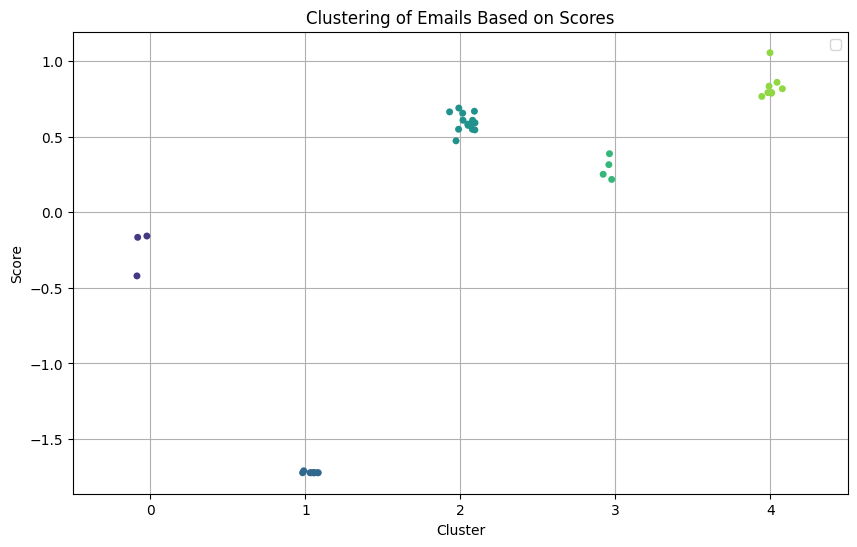

In [111]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=df_agg["cluster"], y=df_agg["score_scaled"], jitter=True, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.title("Clustering of Emails Based on Scores")
plt.legend()
plt.grid()
plt.show()

In [116]:
df_agg.query("cluster == 4")["email"]

9         jimmyzhong@berkeley.edu
12       katiezchang@berkeley.edu
17           mayabwu@berkeley.edu
20       mpjames5468@berkeley.edu
21       nicoleelmor@berkeley.edu
23         oliviafan@berkeley.edu
28    ryusukesuehiro@berkeley.edu
36            vkumud@berkeley.edu
Name: email, dtype: object

##### Wow Leo has a mode of 1???

In [118]:
len(df_tst.query("email == 'leonardo.soffiatti@berkeley.edu' & score == 2.0").value_counts())

38

##### Finally let's see how sexist we are as a club

In [119]:
def filter_source_files_between(df, lower, upper): # keep in mind that the soruce files start with 4
    df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)
    filtered_df = df[(df["file_num"] >= lower) & (df["file_num"] <= upper)]
    filtered_df = filtered_df.drop(columns=["file_num"])

    return filtered_df


In [120]:
df_tst

,email,source_file,score
14970,lilianxu@berkeley.edu,name_196.csv,2.0
14971,mayurihebbar@berkeley.edu,name_196.csv,0.0
14972,shivanisahni@berkeley.edu,name_196.csv,3.0
14973,annacheng@berkeley.edu,name_196.csv,1.0
14974,emilyynhi@berkeley.edu,name_196.csv,2.0
...,...,...,...
204775,NaN,name_4.csv,0.0
204776,NaN,name_4.csv,0.0
204777,NaN,name_4.csv,0.0
204778,NaN,name_4.csv,0.0


In [121]:
df_agg_girl = filter_source_files_between(df_tst, 4, 80).groupby("email")["score"].mean().reset_index()
df_agg_girl.head()

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_23283/1055555342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)


,email,score
0,adorado@berkeley.edu,2.797297
1,anjalidixit@berkeley.edu,2.648649
2,annacheng@berkeley.edu,2.945946
3,benjamin.liang@berkeley.edu,2.608108
4,brennandai@berkeley.edu,2.945946


In [122]:
df_agg_guy = filter_source_files_between(df_tst, 80, 196).groupby("email")["score"].mean().reset_index()
df_agg_guy.head()

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_23283/1055555342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)


,email,score
0,adorado@berkeley.edu,3.042735
1,anjalidixit@berkeley.edu,3.025641
2,annacheng@berkeley.edu,2.820513
3,benjamin.liang@berkeley.edu,2.273504
4,brennandai@berkeley.edu,2.957265


In [123]:
merged_df = pd.merge(df_agg_girl, df_agg_guy, on="email", suffixes=("_df_girl", "_df_guy"))
merged_df["abs_difference"] = (merged_df["score_df_girl"] - merged_df["score_df_guy"])

In [124]:
max_difference = merged_df["abs_difference"].max()
max_diff_emails = merged_df[merged_df["abs_difference"] == max_difference]

print(f"Maximum Absolute Difference: {max_difference}")
print("Email(s) with Maximum Difference:")
print(max_diff_emails)

Maximum Absolute Difference: 2.000231000231
Email(s) with Maximum Difference:
                        email  score_df_girl  score_df_guy  abs_difference
18  mayurihebbar@berkeley.edu       2.837838      0.837607        2.000231


In [137]:
merged_df.sort_values(by="abs_difference", ascending=False).head(10)

,email,score_df_girl,score_df_guy,abs_difference
18,mayurihebbar@berkeley.edu,2.837838,0.837607,2.000231
3,benjamin.liang@berkeley.edu,2.608108,2.273504,0.334604
10,jtao22@berkeley.edu,3.000000,2.786325,0.213675
25,rahilisashaik@berkeley.edu,3.094595,2.905983,0.188612
2,annacheng@berkeley.edu,2.945946,2.820513,0.125433
7,emilyynhi@berkeley.edu,2.918919,2.803419,0.115500
27,rpiao.26@berkeley.edu,2.783784,2.675214,0.108570
37,yashgk99@berkeley.edu,2.918919,2.863248,0.055671
22,nolancostin@berkeley.edu,2.648649,2.598291,0.050358
21,nicoleelmor@berkeley.edu,3.175676,3.128205,0.047471


##### Let's try Vedant's approach now

##### Finally, let's assess voter fatigue

In [126]:
df_tst

,email,source_file,score,file_num
14970,lilianxu@berkeley.edu,name_196.csv,2.0,196
14971,mayurihebbar@berkeley.edu,name_196.csv,0.0,196
14972,shivanisahni@berkeley.edu,name_196.csv,3.0,196
14973,annacheng@berkeley.edu,name_196.csv,1.0,196
14974,emilyynhi@berkeley.edu,name_196.csv,2.0,196
...,...,...,...,...
204775,NaN,name_4.csv,0.0,4
204776,NaN,name_4.csv,0.0,4
204777,NaN,name_4.csv,0.0,4
204778,NaN,name_4.csv,0.0,4


In [128]:
variance_by_file = df_tst.groupby("file_num")["score"].var()
mean_by_file = df_tst.groupby("file_num")["score"].mean()

In [129]:
coeffs = np.polyfit(variance_by_file.index, variance_by_file.values, deg=1)
trend_line_var = np.polyval(coeffs, variance_by_file.index)

coeffs = np.polyfit(mean_by_file.index, mean_by_file.values, deg=1)
trend_line_mean = np.polyval(coeffs, mean_by_file.index)

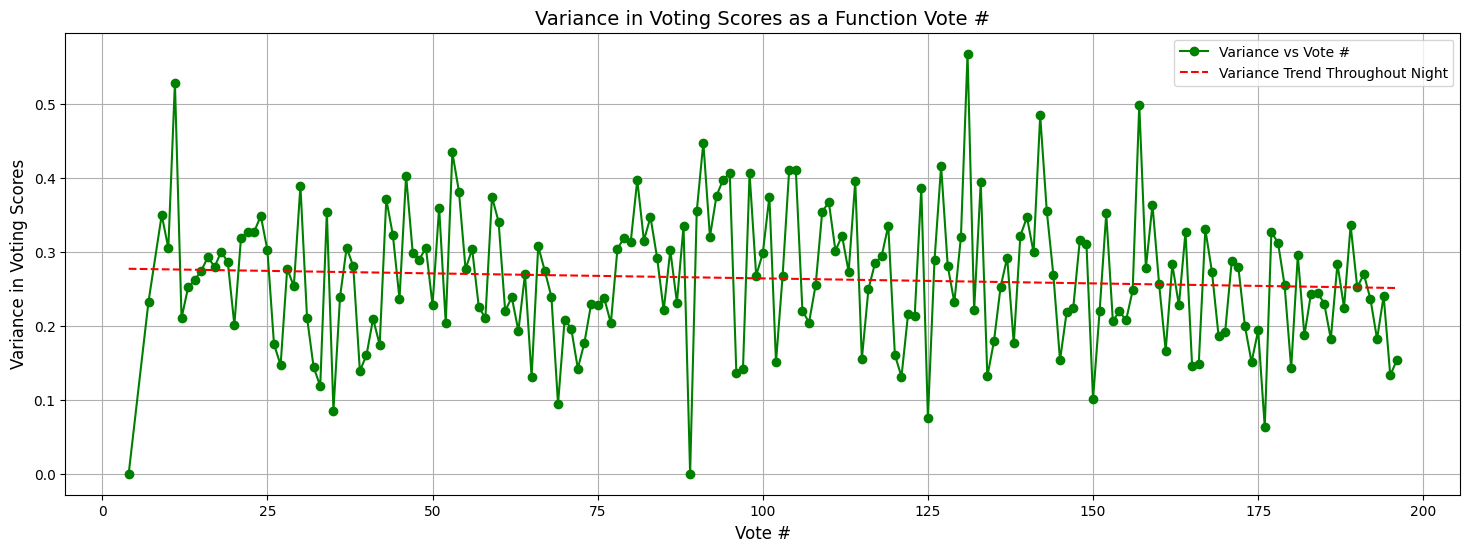

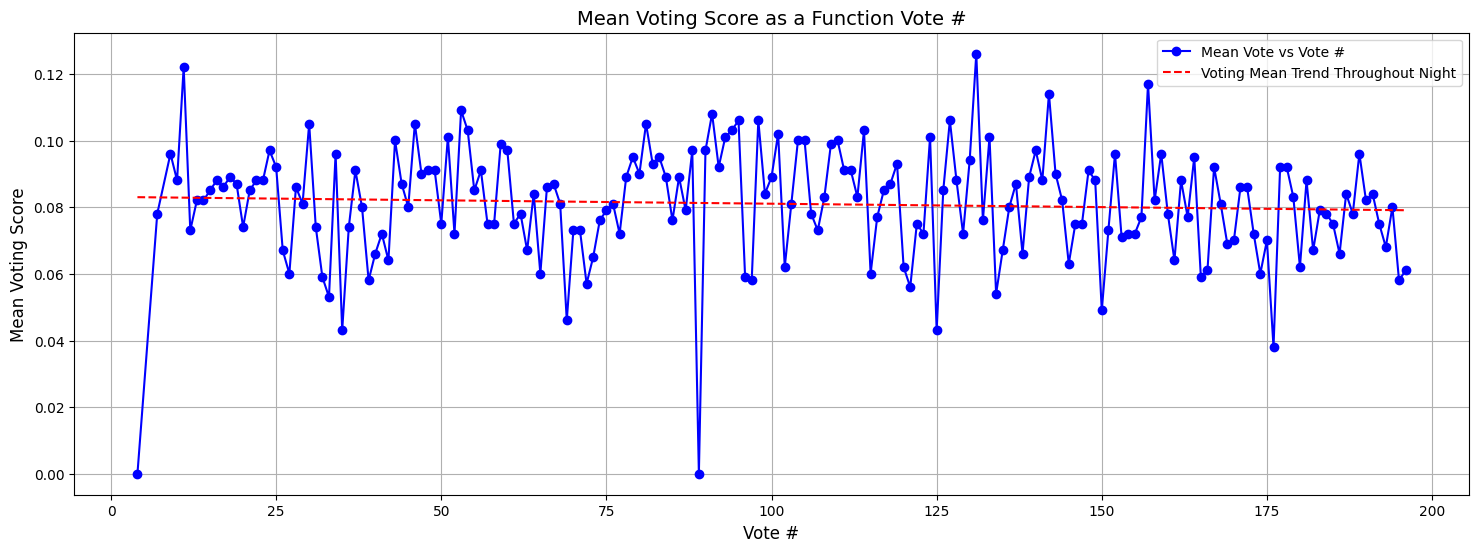

In [130]:
plt.figure(figsize=(18, 6))
plt.plot(variance_by_file.index, variance_by_file.values, marker="o", linestyle="-", color="green", label = "Variance vs Vote #")
plt.plot(variance_by_file.index, trend_line_var, color="red", linestyle="--", label="Variance Trend Throughout Night")
plt.title("Variance in Voting Scores as a Function Vote #", fontsize=14)
plt.xlabel("Vote #", fontsize=12)
plt.ylabel("Variance in Voting Scores", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(mean_by_file.index, mean_by_file.values, marker="o", linestyle="-", color="blue", label = "Mean Vote vs Vote #")
plt.plot(mean_by_file.index, trend_line_mean, color="red", linestyle="--", label="Voting Mean Trend Throughout Night")
plt.title("Mean Voting Score as a Function Vote #", fontsize=14)
plt.xlabel("Vote #", fontsize=12)
plt.ylabel("Mean Voting Score", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


##### Now let's see which voters are most correlated

In [131]:
df_tst.head(5)

,email,source_file,score,file_num
14970,lilianxu@berkeley.edu,name_196.csv,2.0,196
14971,mayurihebbar@berkeley.edu,name_196.csv,0.0,196
14972,shivanisahni@berkeley.edu,name_196.csv,3.0,196
14973,annacheng@berkeley.edu,name_196.csv,1.0,196
14974,emilyynhi@berkeley.edu,name_196.csv,2.0,196


In [132]:
def compute_correlation(df: pd.DataFrame, email_a: str, email_b: str):

    ts_1 = df[df["email"] == email_a]
    ts_2 = df[df["email"] == email_b]

    df_both = pd.merge(ts_1, ts_2, on='source_file', suffixes=("_left", "_right"))
    
    filtered = df_both.dropna(subset=["score_left", "score_right"])
    
    if len(filtered) > 1: 
        return filtered[["score_left", "score_right"]].corr().iloc[0, 1]
    else:
        return None  

In [133]:
email_list = df_tst["email"].dropna().unique()  # Exclude NaN emails
email_pairs = list(combinations(email_list, 2))  # Generate all unique pairs of emails

correlations = []
for email_a, email_b in email_pairs:
    try:
        corr = compute_correlation(df_tst, email_a, email_b)
        if corr is not None: 
            correlations.append({"Email_A": email_a, "Email_B": email_b, "Correlation": corr})
    except Exception as e:
        print(f"Error calculating correlation for {email_a} and {email_b}: {e}")


correlation_df = pd.DataFrame(correlations)
correlation_df = correlation_df.sort_values(by="Correlation", ascending=False)

In [134]:
correlation_df.query("Email_A == 'jimmyzhong@berkeley.edu' or Email_B == 'jimmyzhong@berkeley.edu'").sort_values(by="Correlation", ascending=False).head()

,Email_A,Email_B,Correlation
555,ryusukesuehiro@berkeley.edu,jimmyzhong@berkeley.edu,0.455875
25,lilianxu@berkeley.edu,jimmyzhong@berkeley.edu,0.431860
163,emilyynhi@berkeley.edu,jimmyzhong@berkeley.edu,0.414423
96,shivanisahni@berkeley.edu,jimmyzhong@berkeley.edu,0.409061
481,rahilisashaik@berkeley.edu,jimmyzhong@berkeley.edu,0.406571


##### Vedant ticket

In [176]:
df_agg = df_tst.merge(df_tst.groupby("email")[["score"]].mean().reset_index(), on="email", suffixes=("", "_mean"))
emails_to_remove = ["sselvan@berkeley.edu", "shashaank.joshi@berkeley.edu", "vaarun@berkeley.edu", 
                    "kijunlew@berkeley.edu", "chuyishang@berkeley.edu", "liam.malik@berkeley.edu", 
                    "juliaduan@berkeley.edu", "rohanvis@berkeley.edu", "torinnayak@berkeley.edu"]
df_agg = df_agg[~df_agg["email"].isin(emails_to_remove)]

In [177]:
df_pivot = df_agg.pivot(index="email", columns="file_num", values="score")
df_pivot = df_pivot.fillna(0)
correlation_matrix = df_pivot.T.corr()

In [178]:
df_pivot = df_agg.pivot(index="email", columns="file_num", values="score")
df_pivot = df_pivot.fillna(0)
correlation_matrix = df_pivot.T.corr()

In [179]:
G = nx.Graph()

for email in df_pivot.index:
    G.add_node(email)

for i, email1 in enumerate(df_pivot.index):
    for j, email2 in enumerate(df_pivot.index):
        if i < j:
            weight = correlation_matrix.loc[email1, email2]
            if not np.isnan(weight):  # Only add if weight is valid
                G.add_edge(email1, email2, weight=weight)

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_23283/2605472252.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


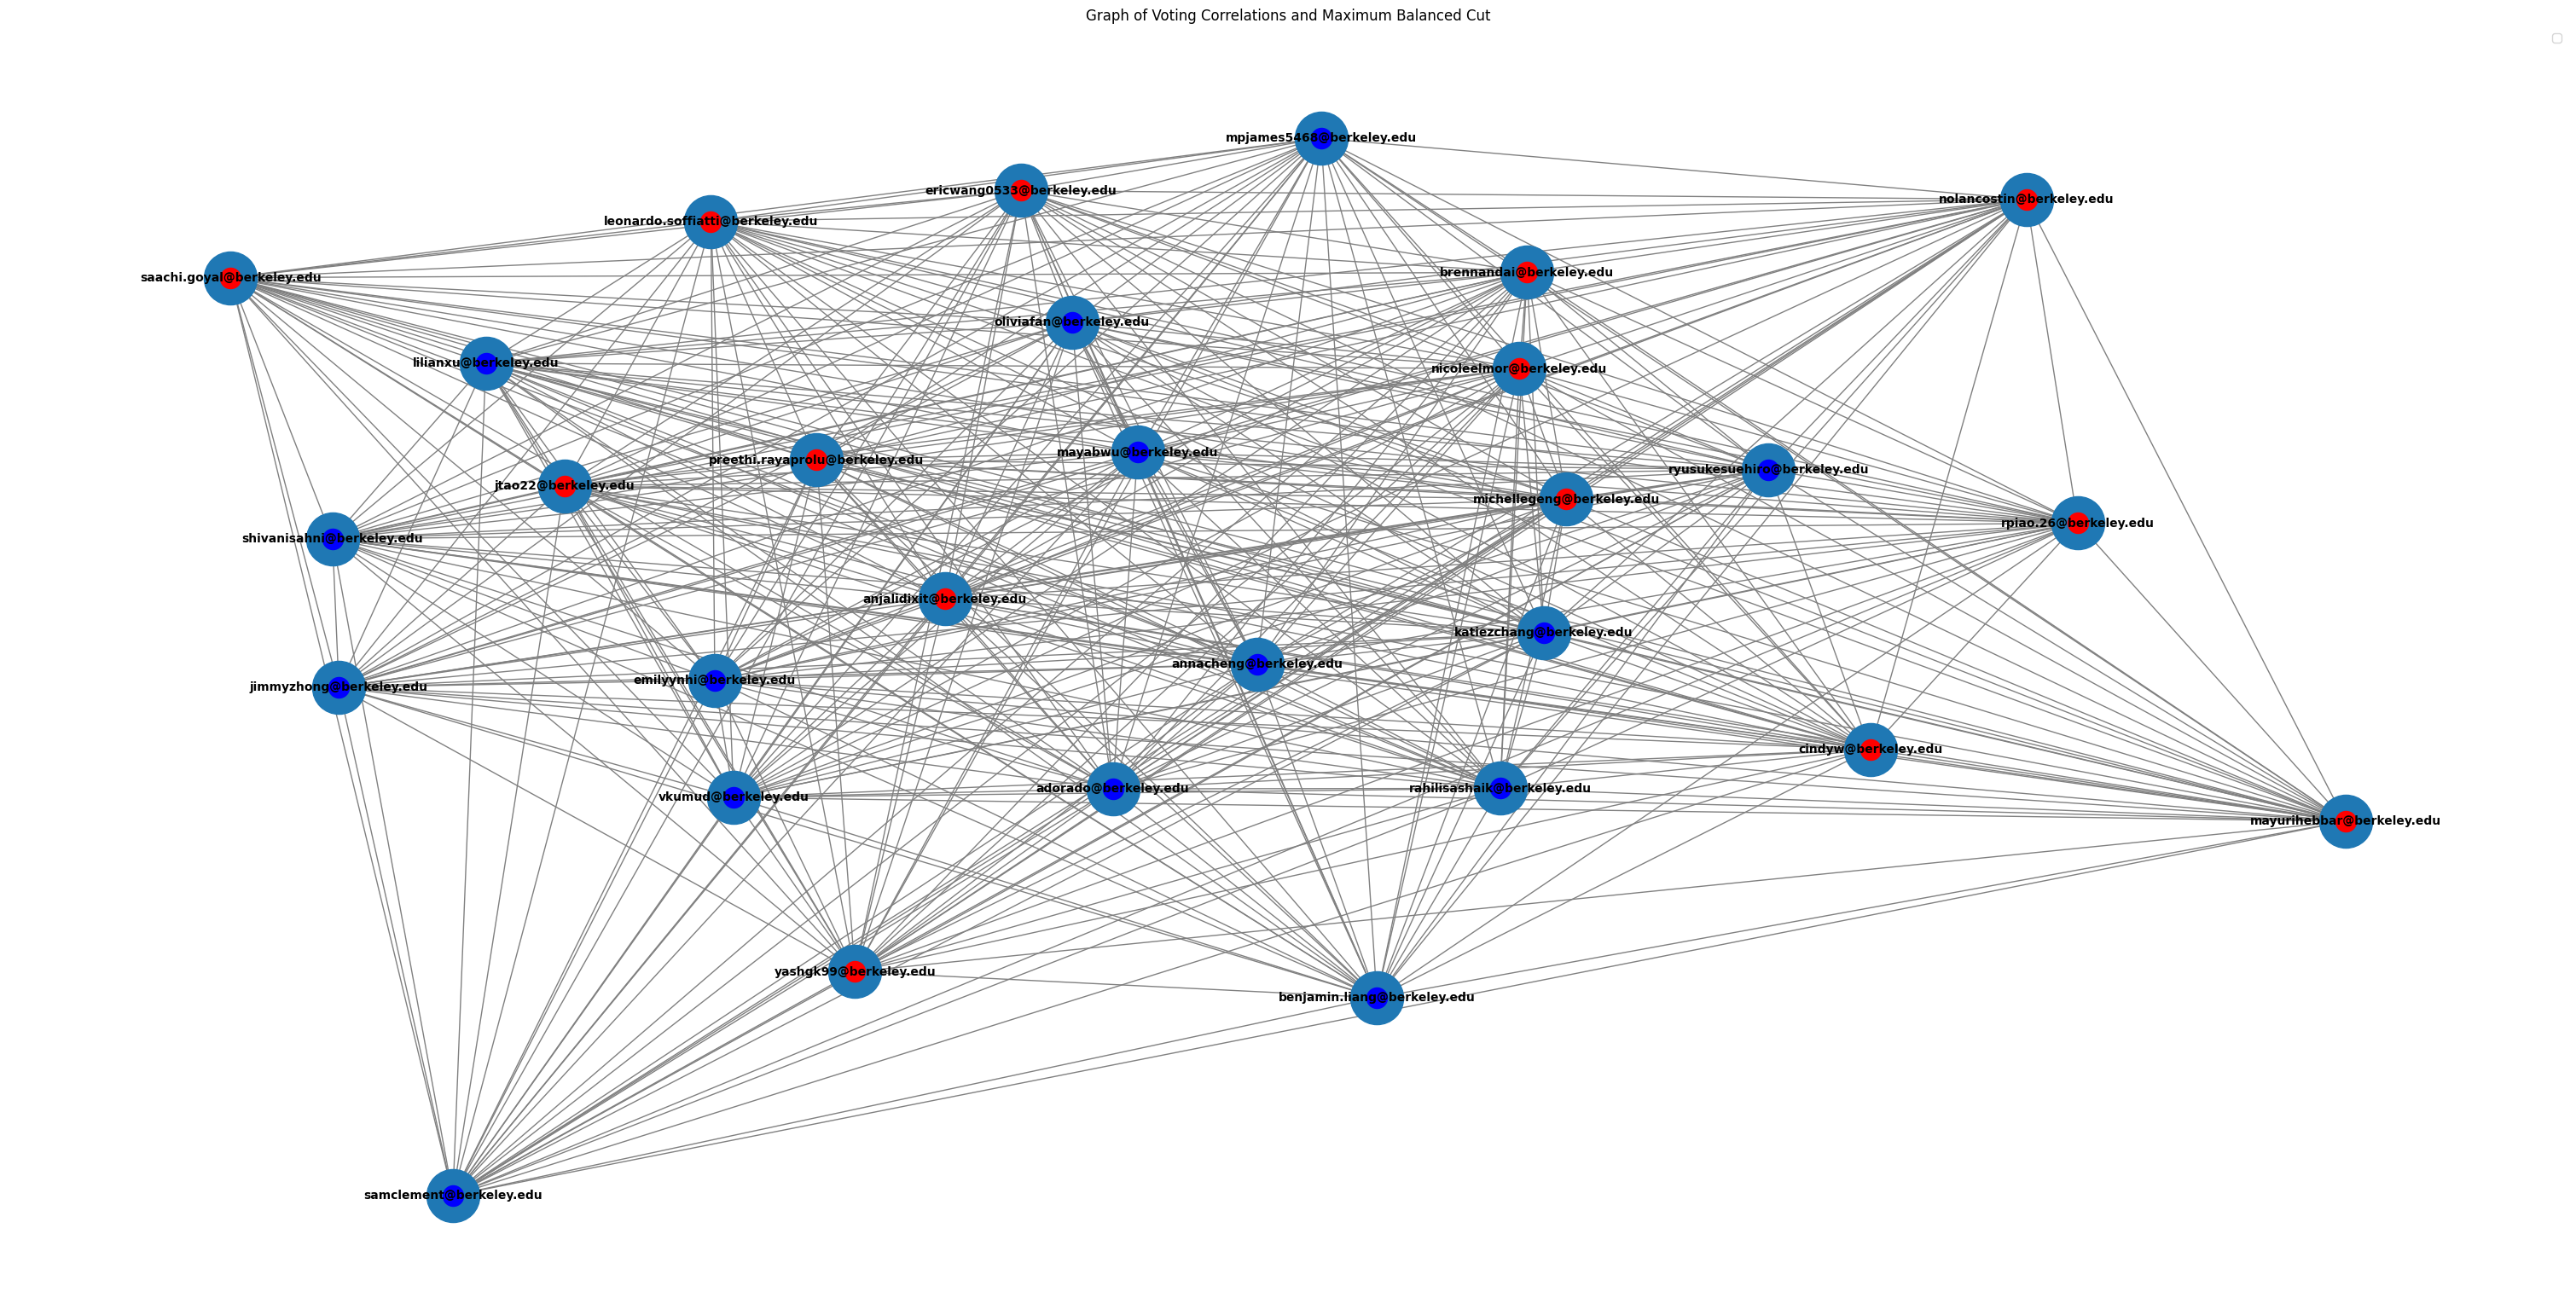


Clusters of People Who Vote Together:

                          Cluster 1                    Cluster 2
0          nolancostin@berkeley.edu       emilyynhi@berkeley.edu
1               jtao22@berkeley.edu    shivanisahni@berkeley.edu
2   leonardo.soffiatti@berkeley.edu        lilianxu@berkeley.edu
3    preethi.rayaprolu@berkeley.edu   rahilisashaik@berkeley.edu
4             yashgk99@berkeley.edu     mpjames5468@berkeley.edu
5          anjalidixit@berkeley.edu         adorado@berkeley.edu
6             rpiao.26@berkeley.edu  benjamin.liang@berkeley.edu
7         mayurihebbar@berkeley.edu       annacheng@berkeley.edu
8         ericwang0533@berkeley.edu      samclement@berkeley.edu
9         michellegeng@berkeley.edu     katiezchang@berkeley.edu
10        saachi.goyal@berkeley.edu       oliviafan@berkeley.edu
11          brennandai@berkeley.edu         mayabwu@berkeley.edu
12              cindyw@berkeley.edu  ryusukesuehiro@berkeley.edu
13         nicoleelmor@berkeley.edu          vkumu

In [181]:
partition = nx.algorithms.community.kernighan_lin_bisection(G, weight="weight")

plt.figure(figsize=(30, 15))
pos = nx.spring_layout(G)  # Positioning
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

colors = ["red", "blue"]
for i, cluster in enumerate(partition):
    nx.draw_networkx_nodes(G, pos, nodelist=cluster, node_color=colors[i])

plt.title("Graph of Voting Correlations and Maximum Balanced Cut")
plt.legend()
plt.show()

clusters = {f"Cluster {i+1}": list(cluster) for i, cluster in enumerate(partition)}

cluster_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in clusters.items()]))
print("\nClusters of People Who Vote Together:\n")
print(cluster_df)


##### Now let's try multiple dimensionality clustering

In [182]:
df_tst

,email,source_file,score,file_num
14970,lilianxu@berkeley.edu,name_196.csv,2.0,196
14971,mayurihebbar@berkeley.edu,name_196.csv,0.0,196
14972,shivanisahni@berkeley.edu,name_196.csv,3.0,196
14973,annacheng@berkeley.edu,name_196.csv,1.0,196
14974,emilyynhi@berkeley.edu,name_196.csv,2.0,196
...,...,...,...,...
204775,NaN,name_4.csv,0.0,4
204776,NaN,name_4.csv,0.0,4
204777,NaN,name_4.csv,0.0,4
204778,NaN,name_4.csv,0.0,4
